# Y3 Gold classification plots

This notebook is intended to be used to create Y3 Gold paper plots: classification

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import kde
#import fitsio
from astropy.io import fits
from astropy.io.fits.hdu.hdulist import HDUList
import healpy as hp
from descolors import BAND_COLORS
import warnings
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
warnings.filterwarnings('ignore')
matplotlib.style.use('des_dr1')
workdir = '/Users/nsevilla/y3gold-paper/'
datadir = workdir+'data/'#'/Volumes/NO NAME/'
figsdir = workdir+'figs/'

In [2]:
#load Alex's skymap utilities
import skymap
from skymap import Skymap,McBrydeSkymap,OrthoSkymap
from skymap import SurveySkymap,SurveyMcBryde,SurveyOrtho
from skymap import DESSkymap

SKYMAPS = [Skymap,McBrydeSkymap,OrthoSkymap]
SURVEYS = [SurveySkymap,SurveyMcBryde,SurveyOrtho]

NSIDE = 4096
NSIDE_deg = 512

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3

In [4]:
import scipy.optimize
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2./(2.*sigma**2))

In [5]:
import matplotlib.lines as mlines
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax],color=BAND_COLORS['r'])
    ax.add_line(l)
    return l

In [16]:
def ratio_error(num,den,dnum,dden):
    return (num*dden+den*dnum)/(num*num)

### Density map and histogram

In [1]:
# we will use the samples downloaded from the DB
# select hpix_4096 as PIXEL, count(*) as SIGNAL from Y3_GOLD_2_2 where flags_footprint = 1 
# and extended_class_mash_sof = 0 (1,2,3) and sof_psf_mag_r BETWEEN 16 AND 23 group by hpix_4096; 
# > /data1/des/y3_validation/stars_sof0_16_23.fits

In [8]:
Y3_density_map = fits.open(datadir+'y3gold_sof0_16_23.fits',memmap=True)
Y3_density_data = Y3_density_map[1].data

/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/sky

In [9]:
Y3_density_data_fullsky_nest_4096 = np.full(hp.nside2npix(NSIDE),hp.UNSEEN)

In [14]:
Y3_density_data_fullsky_nest_4096[Y3_density_data['PIXEL']] = Y3_density_data['SIGNAL']
Y3_density_data_fullsky_ring_4096 = hp.reorder(Y3_density_data_fullsky_nest_4096,n2r=True)

In [15]:
Y3_density_data_fullsky = hp.ud_grade(Y3_density_data_fullsky_ring_4096,nside_out=NSIDE_deg,power=-2)

In [16]:
pix, = np.where(Y3_density_data_fullsky != hp.UNSEEN)
mask = Y3_density_data_fullsky != hp.UNSEEN
nstars = Y3_density_data_fullsky[mask]
print(pix)

[1412238 1412274 1412275 ... 3033079 3033080 3033081]


/anaconda2/envs/skymap/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4759: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


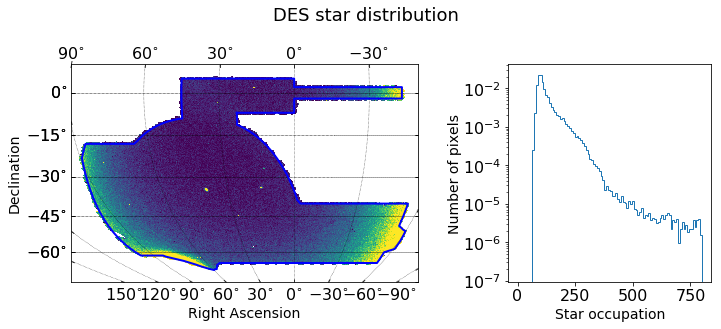

In [18]:
fig = plt.figure(figsize=(12.,4.))
fig.suptitle('DES star distribution', fontsize = 18, y=1.08)
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
smap = DESSkymap()  
#smap.draw_hpxmap(nstars.byteswap().newbyteorder(),pix.byteswap().newbyteorder(),NSIDE,xsize=1000)
smap.draw_hpxmap(nstars,pix,NSIDE_deg,xsize=1000)
#smap.draw_inset_colorbar(fontsize=14)
smap.draw_des()
ax2 = plt.subplot(gs[1])
fig.add_subplot(ax2)
plt.sca(ax2)
plt.xlabel('Star occupation')
plt.ylabel('Number of pixels',labelpad=1)
n,b,p = plt.hist(nstars,normed=True,histtype='step',bins=100,range=[0,800],log=True)
plt.savefig(figsdir+'y3gold_star_distribution_sof_test.png',bbox_inches='tight')

### Generic distributions

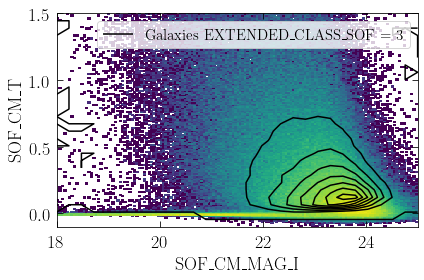

In [4]:
# use a 0.1% sample from gold
Y3_sample = fits.open(datadir+'sample_0.1_y3gold.fits',memmap=True)
Y3_sample = Y3_sample[1].data
nbins= 150
nbins2d = [nbins,nbins]
xmin = 18
xmax = 25
ymin = -0.1#-0.02
ymax = 1.5#0.04
hrange = [[xmin,xmax],[ymin,ymax]]
#mag_string = 'SOF\\_CM\_MAG\_I'
#class_string = 'SOF\_CM\_T'
#classerr_string = 'SOF\_CM\_T\_ERR'
selection_1 = (Y3_sample["SOF_CM_T"] + 5. * Y3_sample["SOF_CM_T_ERR"]) > 0.1
selection_2 = (Y3_sample["SOF_CM_T"] + 1. * Y3_sample["SOF_CM_T_ERR"]) > 0.05
selection_3 = (Y3_sample["SOF_CM_T"] - 1. * Y3_sample["SOF_CM_T_ERR"]) > 0.02
#mag_string = 'MAG\_AUTO\_I'
#class_string = 'SPREAD\_MODEL_I'
#classerr_string = 'SPREADERR\_MODEL_I'
#selection_1 = (Y3_sample['SPREAD\_MODEL_I'] + 3. * Y3_sample['SPREADERR\_MODEL\_I']) > 0.005
#selection_2 = (Y3_sample['SPREAD\_MODEL_I'] + 1. * Y3_sample['SPREADERR\_MODEL\_I']) > 0.003
#selection_3 = (Y3_sample['SPREAD\_MODEL_I'] - 1. * Y3_sample['SPREADERR\_MODEL\_I']) > 0.002
gal_selection = selection_1 & selection_2 & selection_3
plt.clf()
plt.xlabel('SOF\_CM\_MAG\_I')
plt.ylabel('SOF\_CM\_T')#+'+2*'+classerr_string)
plt.hist2d(Y3_sample["SOF_CM_MAG_I"],Y3_sample["SOF_CM_T"],
           bins=nbins2d,cmap='viridis',norm=matplotlib.colors.LogNorm(),range=hrange)
counts,xbins,ybins = np.histogram2d(Y3_sample["SOF_CM_MAG_I"][gal_selection],
                                    Y3_sample["SOF_CM_T"][gal_selection],
                                    range=hrange,bins=[30,30])#,normed=matplotlib.colors.LogNorm())
#data = [Y3_sample[mag_string][gal_selection],Y3_sample[class_string][gal_selection]+2*Y3_sample[classerr_string][gal_selection]]
#data = np.asarray(data).T
#k = kde.gaussian_kde(data)
#xi, yi = np.mgrid[xmin:xmax:20*1j,ymin:ymax:20*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#plt.contour(xi, yi, zi.reshape(xi.shape))

cntr1 = plt.contour(counts.transpose(),extent=[xmin,xmax,ymin,ymax],
            colors='black',linestyles='solid',levels=7)
h1,_ = cntr1.legend_elements()
plt.tight_layout()
plt.legend([h1[0]], ['Galaxies EXTENDED\_CLASS\_SOF = 3'], fontsize=15)
plt.savefig(figsdir+'y3gold_extsof_test.png')
plt.savefig(figsdir+'y3gold_extsof_test.pdf')

### IR checks

In [6]:
xmin = 0
xmax = 4
ymin = -0.25
ymax = 2.5
nbins = 7
mags = np.linspace(15,22,nbins+1)
zmin = 0.3
zmax = 1.2
magmin = 15.0
magmax = 21.0
midmags = (mags[1:] + mags[:-1]) / 2
#for stellar locus in IR plots
p1 = [0,0.55]
p2 = [4.0,1.4]

In [7]:
Y3_vhsmatched_sample = fits.open(datadir+'goldvhs_y3sgsep.fits',memmap=True)
Y3_vhsmatched_sample = Y3_vhsmatched_sample[1].data

In [8]:
Y3_sample = fits.open(datadir+'gold_y3sgsep_forcomparison.fits',memmap=True)
Y3_sample = Y3_sample[1].data

In [9]:
def select_matched_sample(sample,xmin,xmax,ymin,ymax,lo,hi,zmin,zmax):
    selection_1 = (sample['SOF_CM_MAG_G']-sample['SOF_CM_MAG_I']) > xmin
    selection_2 = (sample['SOF_CM_MAG_G']-sample['SOF_CM_MAG_I']) < xmax
    selection_3 = (sample['JAPERMAG3']-sample['KSAPERMAG3']) > ymin
    selection_4 = (sample['JAPERMAG3']-sample['KSAPERMAG3']) < ymax
    selection_5 = sample['SOF_CM_MAG_I'] > lo
    selection_6 = sample['SOF_CM_MAG_I'] < hi
    selection_7 = sample['DNF_ZMEAN_SOF'] > zmin
    selection_8 = sample['DNF_ZMEAN_SOF'] < zmax
    return selection_1 & selection_2 & selection_3 & selection_4 & selection_5 & selection_6 & selection_7 & selection_8

In [10]:
def select_for_ratio(sample,lo,hi,sg):
    selection = ((sample['SOF_CM_MAG_I'] > lo) & 
                 (sample['SOF_CM_MAG_I'] < hi) & 
                 (sample['ALPHAWIN_J2000'] > 0) &
                 (sample['ALPHAWIN_J2000'] < 40) & 
                 (sample['DELTAWIN_J2000'] > -6) &
                 (sample['DELTAWIN_J2000'] < 1.5) &
                 (sample['EXTENDED_CLASS_MASH_SOF'] == sg))
    return selection
def compute_sgratio(sample,lo,hi):
    stars = float(len(sample[select_for_ratio(sample,lo,hi,0)]))
    galaxies = float(len(sample[select_for_ratio(sample,lo,hi,3)]))
    return np.array([stars/galaxies,ratio_error(stars,galaxies,np.sqrt(stars),np.sqrt(galaxies))])
def classify(sample,sg):
    return (sample['EXTENDED_CLASS_MASH_SOF'] == sg)
def stellar_locus_pol1(sample,p1,p2,star):
    x = sample['SOF_CM_MAG_G']-sample['SOF_CM_MAG_I']
    y = sample['JAPERMAG3']-sample['KSAPERMAG3']
    if star:
        return ((x-p1[0])/(p2[0]-p1[0]))*(p2[1]-p1[1])+p1[1]-y > 0 
    else:
        return ((x-p1[0])/(p2[0]-p1[0]))*(p2[1]-p1[1])+p1[1]-y < 0         
def stellar_locus_pol2(sample,pol,padding,star):
    x = sample['SOF_CM_MAG_G']-sample['SOF_CM_MAG_I']
    y = sample['JAPERMAG3']-sample['KSAPERMAG3']
    if star:
        return pol[2]+pol[1]*x+pol[0]*x*x+padding-y > 0
    else:
        return pol[2]+pol[1]*x+pol[0]*x*x+padding-y < 0        

In [17]:
#measure galaxy ratios
sgratio_matched = []
sgratio_onlygold = []
conversion_factor = []
dconversion_factor = []
print('Star/galaxy ratio VHS matched vs Gold only')
for m,mlo in enumerate(mags):
    if m == len(mags)-1:
        continue
    sgratio_matched.append(compute_sgratio(Y3_vhsmatched_sample,mags[m],mags[m+1]))
    sgratio_onlygold.append(compute_sgratio(Y3_sample,mags[m],mags[m+1]))
    conversion_factor.append(sgratio_matched[m][0]/sgratio_onlygold[m][0])
    dconversion_factor.append(ratio_error(sgratio_matched[m][0],sgratio_onlygold[m][0],
                                     sgratio_matched[m][1],sgratio_onlygold[m][1]))
    print("%.1f-%.1f; %.2f+-%.4f; Gold only: %.2f+-%.4f Conversion %.2f+-%.4f" % 
          (mags[m],mags[m+1],sgratio_matched[m][0],sgratio_matched[m][1],
           sgratio_onlygold[m][0],sgratio_onlygold[m][1],conversion_factor[m],dconversion_factor[m]))

Star/galaxy ratio VHS matched vs Gold only
15.0-16.0; 0.79+-0.0620; Gold only: 0.39+-0.0936 Conversion 2.01+-0.1583
16.0-17.0; 1.45+-0.0148; Gold only: 0.82+-0.0202 Conversion 1.78+-0.0197
17.0-18.0; 1.97+-0.0053; Gold only: 1.28+-0.0065 Conversion 1.53+-0.0051
18.0-19.0; 1.18+-0.0054; Gold only: 0.86+-0.0063 Conversion 1.37+-0.0087
19.0-20.0; 0.57+-0.0081; Gold only: 0.45+-0.0087 Conversion 1.27+-0.0263
20.0-21.0; 0.28+-0.0144; Gold only: 0.25+-0.0118 Conversion 1.12+-0.0869
21.0-22.0; 0.13+-0.0466; Gold only: 0.15+-0.0164 Conversion 0.89+-0.5291


In [18]:
def compute_metrics_zrange(sample, conversion_factor, zmin = 0.3, zmax = 1.2):
    ppv_stars = []
    ppv_galaxies = []
    imp_stars = []
    imp_galaxies = []
    print("Contamination according to matched sample, corrected for sg ratio, z=%.1f-%.1f" % (zmin,zmax))
    for m,mid in enumerate(midmags):
        if m == len(midmags):
            continue
        selection = select_matched_sample(sample,xmin,xmax,ymin,ymax,mags[m],mags[m+1],zmin,zmax)
        selection_est_star = selection & classify(sample,0)
        selection_true_star = selection_est_star & stellar_locus_pol1(sample,p1,p2,True) ##0.25 padding for pol2
        ppv_stars.append(float(len(sample[selection_true_star]))/float(len(sample[selection_est_star])))
        imp_stars.append(100*(conversion_factor[m])*(1.0-float(len(sample[selection_true_star]))/float(len(sample[selection_est_star]))))
        #print("%.4f\n" % (float(len(Y3_vhsmatched_sample[selection_true_star]))/float(len(Y3_vhsmatched_sample[selection_est_star]))))
        #print("%.4f\n" % (100*(1.0-float(len(Y3_vhsmatched_sample[selection_true_star]))/float(len(Y3_vhsmatched_sample[selection_est_star])))))
        selection_est_galaxy = selection & classify(sample,3)
        selection_true_galaxy = selection_est_galaxy & stellar_locus_pol1(sample,p1,p2,False)
        ppv_galaxies.append(float(len(sample[selection_true_galaxy]))/float(len(sample[selection_est_galaxy])))
        imp_galaxies.append(100*(1.0/conversion_factor[m])*(1.0-float(len(sample[selection_true_galaxy]))/float(len(sample[selection_est_galaxy]))))
        print("%.1f-%.1f in star sample: %.3f percent; in galaxy sample %.3f percent" % (mags[m],mags[m+1],imp_stars[m], imp_galaxies[m]))
    return imp_stars,imp_galaxies

In [19]:
(imp_stars_source,imp_galaxies_source) = compute_metrics_zrange(Y3_vhsmatched_sample, conversion_factor, 0.3, 1.2)

Contamination according to matched sample, corrected for sg ratio, z=0.3-1.2
15.0-16.0 in star sample: 15.471 percent; in galaxy sample 49.721 percent
16.0-17.0 in star sample: 0.351 percent; in galaxy sample 51.326 percent
17.0-18.0 in star sample: 0.079 percent; in galaxy sample 37.612 percent
18.0-19.0 in star sample: 0.142 percent; in galaxy sample 5.360 percent
19.0-20.0 in star sample: 1.661 percent; in galaxy sample 1.330 percent
20.0-21.0 in star sample: 5.077 percent; in galaxy sample 1.404 percent
21.0-22.0 in star sample: 7.541 percent; in galaxy sample 2.132 percent


In [22]:
(imp_stars_02,imp_galaxies_02) = compute_metrics_zrange(Y3_vhsmatched_sample, conversion_factor, 0.0, 2.0)

Contamination according to matched sample, corrected for sg ratio, z=0.0-2.0
15.0-16.0 in star sample: 0.137 percent; in galaxy sample 9.357 percent
16.0-17.0 in star sample: 0.164 percent; in galaxy sample 6.986 percent
17.0-18.0 in star sample: 0.320 percent; in galaxy sample 3.753 percent
18.0-19.0 in star sample: 0.926 percent; in galaxy sample 2.299 percent
19.0-20.0 in star sample: 3.296 percent; in galaxy sample 1.688 percent
20.0-21.0 in star sample: 6.681 percent; in galaxy sample 1.514 percent
21.0-22.0 in star sample: 8.046 percent; in galaxy sample 2.130 percent


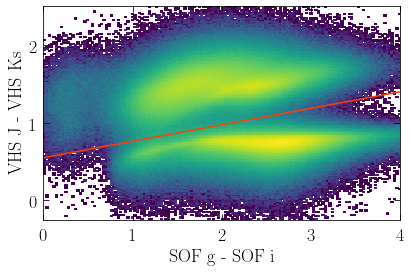

In [11]:
xstring = 'SOF_CM_MAG_G-SOF_CM_MAG_I'
ystring = 'JAPERMAG3-KSAPERMAG3'
nbins= 150
nbins2d = [nbins,nbins]
hrange = [[xmin,xmax],[ymin,ymax]]
selection = select_matched_sample(Y3_vhsmatched_sample,xmin,xmax,ymin,ymax,magmin,magmax,zmin,zmax)
selection_locus = stellar_locus_pol1(Y3_vhsmatched_sample,p1,p2,True) 
plt.clf()
plt.xlabel('SOF g - SOF i')
plt.ylabel('VHS J - VHS Ks')
dummy = plt.hist2d(Y3_vhsmatched_sample['SOF_CM_MAG_G'][selection]-Y3_vhsmatched_sample['SOF_CM_MAG_I'][selection],
                   Y3_vhsmatched_sample['JAPERMAG3'][selection]-Y3_vhsmatched_sample['KSAPERMAG3'][selection],
                   bins=nbins2d,cmap='viridis',norm=matplotlib.colors.LogNorm(),range=hrange)
newline(p1,p2)
selection_lo = selection & selection_locus
plt.tight_layout()
plt.savefig(figsdir+'y3gold_vhs_colors_v2.png',dpi=300)
plt.savefig(figsdir+'y3gold_vhs_colors_v2.pdf',dpi=300)
#pol3 = np.polyfit(Y3_vhsmatched_sample['SOF_CM_MAG_G'][selection_lo]-Y3_vhsmatched_sample['SOF_CM_MAG_I'][selection_lo],
           #Y3_vhsmatched_sample['JAPERMAG3'][selection_lo]-Y3_vhsmatched_sample['KSAPERMAG3'][selection_lo],3)
#pol2 = np.polyfit(Y3_vhsmatched_sample['SOF_CM_MAG_G'][selection_lo]-Y3_vhsmatched_sample['SOF_CM_MAG_I'][selection_lo],
           #Y3_vhsmatched_sample['JAPERMAG3'][selection_lo]-Y3_vhsmatched_sample['KSAPERMAG3'][selection_lo],2)
#x = np.linspace(xmin,xmax,100)
#y = pol3[3]+pol3[2]*x+pol3[1]*x*x+pol3[0]*x*x*x+0.2
#y = pol2[2]+pol2[1]*x+pol2[0]*x*x+0.25
#plt.plot(x,y,'k')

<Figure size 432x288 with 0 Axes>

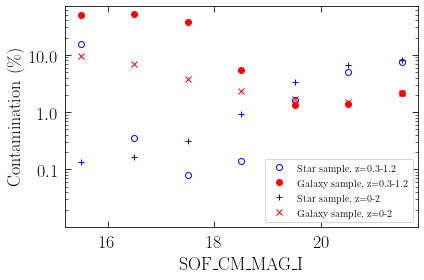

In [24]:
plt.clf()
fig, ax = plt.subplots(1, 1)
xstring = 'SOF\_CM\_MAG\_I'
ystring = 'Contamination (\%)'
ax.set_xlabel(xstring)
ax.set_ylabel(ystring)
ax.set_yscale('log')
ax.set_yticks((0.1, 1, 10))
ax.set_ylim(0.01, 70)
import matplotlib.ticker
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.plot(midmags,imp_stars_source,'bo',label='Star sample, z=0.3-1.2',markerfacecolor='none')
ax.plot(midmags,imp_galaxies_source,'ro',label='Galaxy sample, z=0.3-1.2')
ax.plot(midmags,imp_stars_02,'b+',label='Star sample, z=0-2')
ax.plot(midmags,imp_galaxies_02,'rx',label='Galaxy sample, z=0-2')
ax.legend()
plt.tight_layout()
plt.savefig(figsdir+'contamination_test.png')
plt.savefig(figsdir+'contamination_v2.pdf')